In [1]:
%load_ext autoreload
%autoreload 2

Pytorch EO is designed to work with any combination of inputs-outputs:

- 0 inputs, 1 output: can be useful to explore labels
- 1 input, 0 outputs: can be useful to explore inputs and for unsupervised learning.
- 1 input, 1 output: typical supervised learning
- N inputs, 0 outputs: explore inputs and unsupervised learning
- N inputs, 1 output: single-task data fusion and multi-modality
- 1 input, N outputs: single-source, multi-task learning
- N inputs, N outputs: data fusion, multi-modality, multi-task learning

To do so we define Pytorch `Datasets` for each input and output modality (i.e images and metadata for inputs and labels, bounding boxes, masks, etc, for outputs). For training, we create a `ConcatDataset` to iterate over the desired combination of inputs-outputs.

Our design philosophy is to load data as `numpy` arrays. For images, we keep channels last and the original dtype. We use `albumentations` por data augmentation. 

The following code will download the EuroSAT dataset RGB version.

In [2]:
import os
from pytorch_eo.utils import download_url, unzip_file
from pathlib import Path

path = Path('data')
os.makedirs(path, exist_ok=True)

url = "http://madm.dfki.de/files/sentinel/EuroSAT.zip"
compressed_data_filename = 'EuroSAT.zip'
compressed_data_path = path / compressed_data_filename
download_url(url, compressed_data_path)

unzip_file(compressed_data_path, path, msg="extracting data ...")

extracting data ...: 100%|██████████| 27011/27011 [00:02<00:00, 11531.39it/s]


Now we can find our images and labels. Each dataset may have its own pre-processing steps, in this case the labels are encoded in the folder name and images can be found inside each folder.

In [55]:
data_folder = '2750'
uncompressed_data_path = path / data_folder
classes = sorted(os.listdir(uncompressed_data_path))
classes

['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake']

In [56]:
import pandas as pd

images, labels = [], []
for ix, label in enumerate(classes):
    _images = os.listdir(uncompressed_data_path / label)
    images += [str(uncompressed_data_path /
                label / img) for img in _images]
    labels += [ix]*len(_images)

df = pd.DataFrame({'image': images, 'label': labels})

df.sample(5)

,image,label
19720,data/2750/Residential/Residential_1777.jpg,7
13587,data/2750/Industrial/Industrial_529.jpg,4
13106,data/2750/Industrial/Industrial_221.jpg,4
2828,data/2750/AnnualCrop/AnnualCrop_440.jpg,0
24004,data/2750/SeaLake/SeaLake_422.jpg,9


Nevertheless, we will always end up with the same: a list of paths to images and the corresponding labels (or bounding boxes, segmentation masks, ...), pairs of inputs-outputs to feed and train our model.

## Data splits

The first thing that we need is to split our data in train and test. This is important for reproducibility (comparing our results to others) as long as we use the same splits. Sometimes this splits will already be provided, in this case we build them ourselves. 

Additionally, we may want to use a validation split for hyperparameter optimization. The approach we take in pytorch EO is to have all our data in one Dataframe and then provide the indices to be used for train-test-validation. This simplifies our lives when defining different validation strategies (no validation, validation with a subset or cross validation). If train-test-validation splits are provided to you, first make sure to merge all the data in one Dataframe.

First, we need a dataset.

In [58]:
from pytorch_eo.utils.datasets.ArrayDataset import ArrayDataset
from pytorch_eo.utils.datasets.RGBImageDataset import RGBImageDataset
from pytorch_eo.utils.datasets.ConcatDataset import ConcatDataset

images_ds = RGBImageDataset(images)
labels_ds = ArrayDataset(labels)

# pass inputs and outputs as dicts, so we know where to apply transforms 

ds = ConcatDataset({'images': images_ds}, {'labels': labels_ds})

len(ds)

27000

The dataset will contain all the available samples.

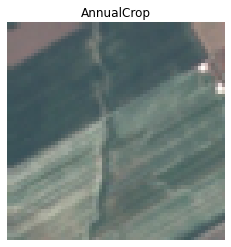

In [61]:
import random 
import matplotlib.pyplot as plt

ix = random.randint(0, len(ds)-1)

img, label = ds[ix]

fig = plt.figure()
ax = plt.subplot(1,1,1)
ax.imshow(img) # unit8 (h, w, c)
ax.set_title(classes[label.item()])
ax.axis('off')
plt.show()

In order to train a model, we will need a DataLoader. This is the objet responsible for efficiently loading data and batching it. It is at this point when we split the data into train-validation-test, by providing a `Sampler`. 

In [62]:
from torch.utils.data import DataLoader, SequentialSampler

sampler = SequentialSampler([0, 1, 2])

len(sampler)

3

In [63]:
# this will always return the first 3 images in the dataset

dl = DataLoader(ds, batch_size=3, sampler=sampler)

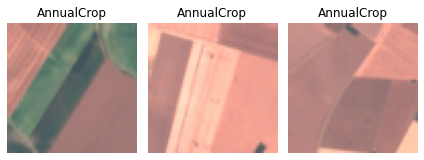

In [65]:
def plot_batch(batch):
    imgs, labels = batch
    fig = plt.figure()
    for ix, (img, label) in enumerate(zip(imgs, labels)):
        ax = plt.subplot(1,len(imgs), ix + 1)
        ax.imshow(img)
        ax.set_title(classes[label.item()])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

batch = next(iter(dl))
plot_batch(batch)

In [67]:
from torch.utils.data import DataLoader, SubsetRandomSampler

# this will always return the first 3 images randomly

sampler = SubsetRandomSampler([0, 1, 2])
dl = DataLoader(ds, batch_size=3, sampler=sampler)

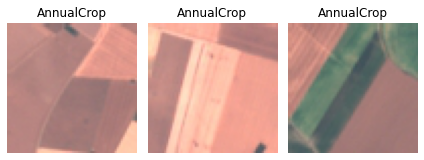

In [69]:
batch = next(iter(dl))
plot_batch(batch)

Check for available samplers [here](https://pytorch.org/docs/stable/data.html).

### Train-Test splits

In [70]:
test_size = 0.2 # use 20% of the data for testing
idxs = list(range(len(ds)))
testset_len = int(len(ds)*test_size)
trainset_len = len(ds) - testset_len

trainset_len, testset_len

(21600, 5400)

Use last 20% of the data for testing

In [71]:
train_idxs = idxs[:trainset_len]
test_idxs = idxs[trainset_len:]

len(train_idxs), len(test_idxs)

(21600, 5400)

This can be problematic in some cases (unbalanced class distributions)

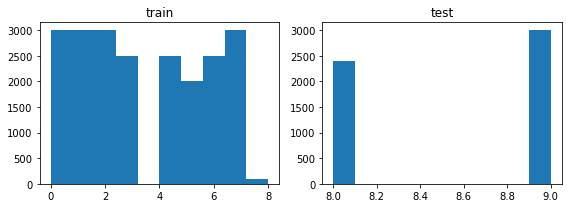

In [72]:
import numpy as np

def plot_class_balance(train_idxs, test_idxs):
    fig = plt.figure(figsize=(8, 3))
    ax = plt.subplot(1,2,1)
    ax.hist(np.array(labels)[train_idxs], bins=len(classes))
    ax.set_title('train')
    ax = plt.subplot(1,2,2)
    ax.hist(np.array(labels)[test_idxs], bins=len(classes))
    ax.set_title('test')
    plt.tight_layout()
    plt.show()

plot_class_balance(train_idxs, test_idxs)

Better to random split given size and a seed (use same size and seed to compare with others).

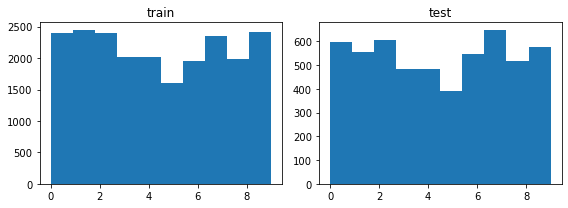

In [73]:
# using numpy

import numpy as np

np.random.shuffle(idxs)

train_idxs = idxs[:trainset_len]
test_idxs = idxs[trainset_len:]

plot_class_balance(train_idxs, test_idxs)

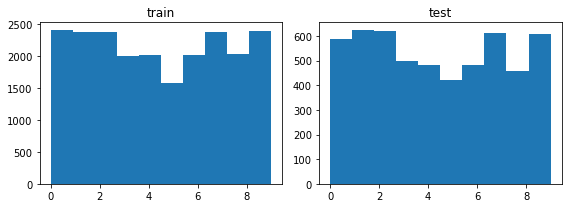

In [74]:
# using pytorch

import torch
from torch.utils.data import random_split

seed = 42
train_idxs, test_idxs = random_split(idxs, [trainset_len, testset_len], generator=torch.Generator().manual_seed(seed))

plot_class_balance(train_idxs, test_idxs)

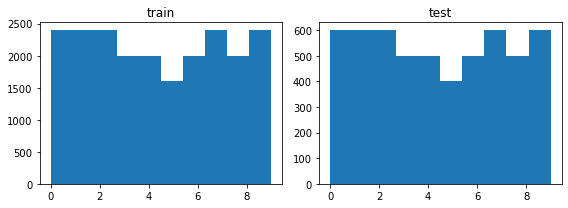

In [75]:
# or better yet, stratify by label

from sklearn.model_selection import train_test_split

idxs = list(range(len(ds)))
train_idxs, test_idxs = train_test_split(idxs, test_size=test_size, shuffle=True, stratify=labels, random_state=seed)

plot_class_balance(train_idxs, test_idxs)

### Validation split

Use a subset of training data

In [76]:
val_size = 0.2 # use 20% of the training data for validating
idxs = list(range(len(ds)))
valset_len = int(len(ds)*val_size)
trainset2_len = trainset_len - valset_len

trainset2_len, valset_len, testset_len

(16200, 5400, 5400)

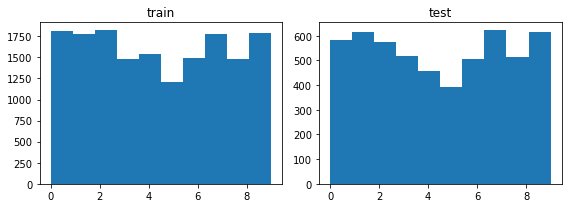

In [77]:
seed = 42
train2_idxs, val_idxs = random_split(train_idxs, [trainset2_len, valset_len], generator=torch.Generator().manual_seed(seed))

plot_class_balance(train2_idxs, val_idxs)

Or use cross validation

In [78]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
skf.get_n_splits(idxs)

5

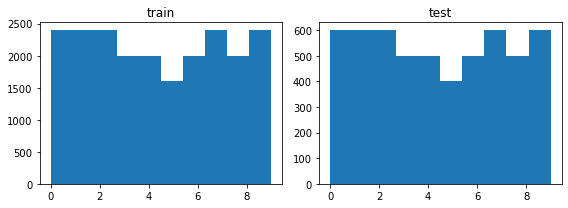

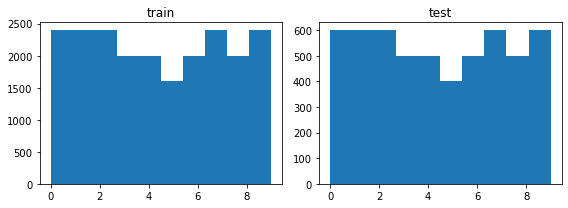

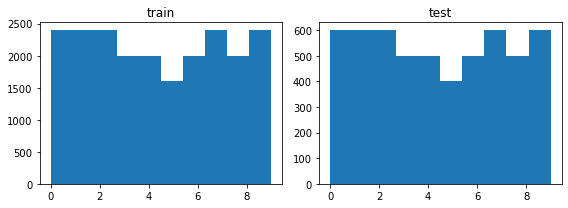

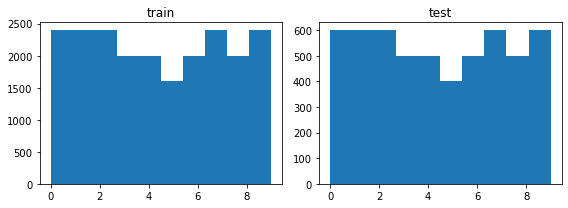

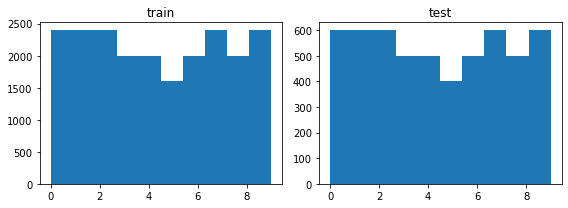

In [79]:
for train_index, val_index in skf.split(idxs, labels):
    plot_class_balance(train_index, val_index)

## Conclusions

In this tutorial we have shown you how data loading works in Pytorch EO. The main ideas to keep in mind are:

2. Gather all your data into one Dataframe (in case train-val-test splits are provided)
3. Build one Dataset for each input-output, for training you can concatenate them.
4. Compute list of indices for each split (train-val-test). Use your favorite method here, we default to random splits with `Pytorch`.
5. Define one DataLoader per split using `Samplers` to define the data used in the split and the concatenated Dataset.
6. When working with images, the dataloaders will return images in the original dtype (as long as its supported by pytorch) with the channels dimensions last.